# Global birth rate analysis

Birth rate by country and the global birth rate will be analyzed under the impacts of the following factors: 
- Financial: GDP per Capita
- Social: Happiness index, Social support score, life expectancy, freedom to make life choices, generosity,perception of corruption
- Jobs: Unemployment rate

In [74]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn import linear_model
from scipy import stats
import statsmodels.api as sm
import matplotlib.pyplot as plt
from statsmodels.stats.stattools import durbin_watson

## Data Import & Data Preparation

In [33]:
# Data import
df_birth_rate = pd.read_csv("birth_rate.csv")
df_gdp = pd.read_csv("GDP.csv")
df_happiness_index = pd.read_excel("DataForFigure2.1WHR2023.xls")
df_unemployment_rate = pd.read_csv('unemployment_rate.csv')


In [34]:
# Drop duplicates & rename columns
df_birth_rate = df_birth_rate.rename({'country': 'Country'}, axis='columns')
df_gdp = df_gdp.drop_duplicates(subset='country', keep='first')
df_gdp = df_gdp.rename({'country': 'Country'}, axis='columns')
df_happiness_index = df_happiness_index.rename({'Country name': 'Country'},
                                               axis='columns')
df_unemployment_rate = df_unemployment_rate.rename({'country': 'Country'},
                                                    axis='columns')


In [35]:
# Preliminary variable selection
df_birth_rate = df_birth_rate[['birthRate', 'Country']]
df_gdp = df_gdp[['Country', 'gdpPerCapita']]
df_happiness_index = df_happiness_index[['Country', 'Ladder score', 'Social support', 
                                         'Healthy life expectancy',
                                         'Freedom to make life choices', 
                                         'Generosity', 'Perceptions of corruption']]
df_unemployment_rate = df_unemployment_rate[['Country', 'rateWb']]

In [36]:
# Main data frame preparation
df_final = df_birth_rate.merge(df_gdp,
                                on='Country').merge(df_happiness_index,
                                                     on='Country').merge(df_unemployment_rate, on='Country')
df_final.columns

Index(['birthRate', 'Country', 'gdpPerCapita', 'Ladder score',
       'Social support', 'Healthy life expectancy',
       'Freedom to make life choices', 'Generosity',
       'Perceptions of corruption', 'rateWb'],
      dtype='object')

In [37]:
df_final[['gdpPerCapita', 'Social support', 'Freedom to make life choices', 'Generosity', 'Perceptions of corruption']] = df_final[['gdpPerCapita', 'Social support', 'Freedom to make life choices', 'Generosity', 'Perceptions of corruption']]*100

In [38]:
df_final.loc[128,'rateWb'] = 3.56

In [39]:
# Data partition
df_predictors = df_final[['gdpPerCapita', 'Ladder score', 'Social support', 
                          'Healthy life expectancy', 'Freedom to make life choices',
                          'Generosity', 'Perceptions of corruption', 'rateWb']]
df_target = df_final['birthRate']

x_train, x_test, y_train, y_test = train_test_split(df_predictors,df_target,test_size=0.25)


## Model Fit & Model result

In [40]:
model = linear_model.LinearRegression()

In [41]:
model.fit(x_train,y_train)

LinearRegression()

In [42]:
# birth_rate fitted and birth_rate prediction
y_fitted = model.predict(x_train)
y_predict = model.predict(x_test)

In [43]:
# residuals from train & test
residuals_train = y_train - y_fitted
residuals_test = y_test - y_predict

In [44]:
# Coefficients
coef_gdp = model.coef_[0]
coef_happiness_index = model.coef_[1]
coef_social_support = model.coef_[2]
coef_life_expectancy = model.coef_[3]
coef_freedom = model.coef_[4]
coef_generosity = model.coef_[5]
coef_corruption = model.coef_[6]
coef_unemployment = model.coef_[7]
intercept = model.intercept_
model.coef_

array([-9.91342829e-08, -1.28571042e+00, -1.00673288e-01, -1.12602969e+00,
        6.32055579e-03,  2.15207413e-02, -8.85648960e-02, -6.13557098e-02])

In [45]:
print('model = %f + %f GDP %f Happiness index  %f Social support %f life expectancy  %f freedom  %f generosity  %f corruption  %f Unemployment' % (intercept, coef_gdp, coef_happiness_index, coef_social_support, coef_life_expectancy, coef_freedom, coef_generosity, coef_corruption, coef_unemployment))

model = 113.756667 + -0.000000 GDP -1.285710 Happiness index  -0.100673 Social support -1.126030 life expectancy  0.006321 freedom  0.021521 generosity  -0.088565 corruption  -0.061356 Unemployment


In [46]:
stats_model = sm.OLS(y_train, x_train).fit()

## Model & Predictors Evaluation

In [75]:
def model_significance(y_train_set, y_pred, p):
    y_mean = np.mean(y_train_set)
    tss = ((y_train_set - y_mean)**2).sum()
    rss = ((y_train_set - y_pred)**2).sum()
    n = len(y_train_set)
    f_test = (tss-rss)/(rss/(n-p-1))
    print(f_test)
    if f_test > 1:
        print("Reject Ho. At least one of the model coefficients is significant.")
    if f_test <=1: 
        print("Accept Ho. No coefficients are useful.")


def coefficient_testing(coeff, residuals, trainset,p):
    """Perform Hypothesis testing to determine if Coefficient in regression is significant"""
    # Obtain the residual standard deviation
    residual_variance = np.var(residuals)
    x_mean = np.mean(trainset)
    x_squared = ((trainset - x_mean)**2).sum()
    coeff_var = residual_variance/ x_squared
    coeff_std = np.sqrt(coeff_var)
    print("coeff_var, std:",coeff_var, coeff_std)
    # Obtain t test
    print("Hypothesis: Ho: B1 = 0, Ha: B1 !=0")
    t_value = coeff/coeff_std
    print("t_value:", t_value)
    degree_of_freedom = len(trainset) - p -1
    p_value = stats.t.sf(abs(t_value), degree_of_freedom)*2
    print ("p_value: %.24f" % p_value)
    # Conclusion:
    if p_value < 0.05:
        print('Reject Ho. The coefficient is significant, and has a relationship with the respond variable')
    if p_value > 0.05: 
        print('Accept Ho. The coefficient is not significant, and does not have a relationship with respond variable')
    return None


def residual_zero_mean(residuals,p):
    n = len(residuals)
    residual_mean = np.mean(residuals)
    residual_std = np.std(residuals)
    t_test = (residual_mean)/(residual_std/np.sqrt(n))
    p_value = stats.t.sf(t_test, n - p - 1)
    if p_value > 0.05:
        print("As the p_value is larger than 0.05, there is no sufficient evidence to reject Ho. From this, residuals mean is equal to 0. Linear regression assumption on residuals is appropriate.")
    elif p_value <= 0.05: 
        print("As p_value is smaller than 0.95, there is sufficient evidence to reject Ho. Thus zero mean assumption is not appropriate.")

def tss_rss(y_train, y_pred):
    y_mean = np.mean(y_train)
    tss = ((y_train - y_mean)**2).sum()
    rss = ((y_train - y_pred)**2).sum()
    n = len(y_train)
    return tss, rss

def autocorrelation(residuals):
    print("Ho: There is no correlation among residuals")
    print("Ha: There is correlation between residuals")
    test = durbin_watson(residuals)
    print(test)
    if test>= 0 and test <= 1.5: 
        print("Reject Ho. There is sufficient evidence indicating a positive correlation in the residuals.")
    elif test > 1.5 and test <= 2.5:
        print("Do not reject Ho. There is no correlation among residuals.")
    elif test > 2.5:
        print("Reject Ho. There is sufficient evidence indicating a negative correlation in the residuals")
        


### Model Evaluation

In [48]:
# Model evaluation - F test
model_significance(y_train, y_fitted, 8)

254.18029497132937
Reject Ho. At least one of the model coefficients is significant.


### Coefficient evaluation


In [49]:
# GDP coefficient
coefficient_testing(coef_gdp, residuals_train, x_train['gdpPerCapita'],8)

coeff_var, std: 3.1665698030562854e-14 1.7794858254721462e-07
Hypothesis: Ho: B1 = 0, Ha: B1 !=0
t_value: -0.5570950974965073
p_value: 0.578860792427326797948695
Accept Ho. The coefficient is not significant, and does not have a relationship with respond variable


In [50]:
# Happiness index
coefficient_testing(coef_happiness_index, residuals_train, x_train['Ladder score'], 8)

coeff_var, std: 0.176985348920321 0.42069626682479727
Hypothesis: Ho: B1 = 0, Ha: B1 !=0
t_value: -3.056148867278516
p_value: 0.002959273751425215131378
Reject Ho. The coefficient is significant, and has a relationship with the respond variable


In [51]:
# Social support
coefficient_testing(coef_social_support, residuals_train, x_train['Social support'],8)

coeff_var, std: 0.0015304163469310995 0.03912053612785872
Hypothesis: Ho: B1 = 0, Ha: B1 !=0
t_value: -2.573412779595602
p_value: 0.011724407474947053098280
Reject Ho. The coefficient is significant, and has a relationship with the respond variable


In [52]:
# Healthy life expectancy
coefficient_testing(coef_life_expectancy, residuals_train, x_train['Healthy life expectancy'], 8)

coeff_var, std: 0.007760409757403623 0.08809318791713479
Hypothesis: Ho: B1 = 0, Ha: B1 !=0
t_value: -12.782256108932161
p_value: 0.000000000000000000000748
Reject Ho. The coefficient is significant, and has a relationship with the respond variable


In [53]:
# Freedom to make life choices
coefficient_testing(coef_freedom, residuals_train, x_train['Freedom to make life choices'], 8)


coeff_var, std: 0.0021495191509208335 0.046362907058561734
Hypothesis: Ho: B1 = 0, Ha: B1 !=0
t_value: 0.13632785765215588
p_value: 0.891870002181171961375128
Accept Ho. The coefficient is not significant, and does not have a relationship with respond variable


In [54]:
# Generosity
coefficient_testing(coef_generosity, residuals_train, x_train['Generosity'], 8)

coeff_var, std: 0.001236056363347712 0.035157593253061455
Hypothesis: Ho: B1 = 0, Ha: B1 !=0
t_value: 0.6121221436055512
p_value: 0.542017652179659581435089
Accept Ho. The coefficient is not significant, and does not have a relationship with respond variable


In [55]:
# Perceptions of corruption
coefficient_testing(coef_corruption, residuals_train, x_train['Perceptions of corruption'], 8)

coeff_var, std: 0.0008009805851692443 0.028301600399434027
Hypothesis: Ho: B1 = 0, Ha: B1 !=0
t_value: -3.129324659151941
p_value: 0.002369327889955632690522
Reject Ho. The coefficient is significant, and has a relationship with the respond variable


In [56]:
# Unemployment rate: rateWb
coefficient_testing(coef_unemployment, residuals_train, x_train['rateWb'], 8)

coeff_var, std: 0.008687572810379992 0.0932071499960169
Hypothesis: Ho: B1 = 0, Ha: B1 !=0
t_value: -0.6582725659672559
p_value: 0.512062238753223430975936
Accept Ho. The coefficient is not significant, and does not have a relationship with respond variable


## Accuracy Evaluation

#### Train set

In [57]:
tss_train, rss_train = tss_rss(y_train, y_fitted)

In [58]:
n_train = len(y_train)
rse_train = np.sqrt(rss_train/(n_train-8-1))
r_squared_train = (tss_train-rss_train)/tss_train

In [59]:
print("RSE:", rse_train)
print("R-squared:", r_squared_train)

RSE: 5.019901708045248
R-squared: 0.7406611005814439


#### Test set

In [60]:
tss_test, rss_test = tss_rss(y_test, y_predict)
n_test = len(y_test)
rse_test = np.sqrt(rss_test/(n_test - 8-1))
r_squared_test = (tss_test-rss_test)/tss_test

In [61]:
print("RSE:", rse_test)
print("R-squared:", r_squared_test)

RSE: 5.192886247773865
R-squared: 0.8437279076799588


## Residuals Evaluation

Residuals will be assessed for the following factors: 
- Mean of zero
- Normally distributed
- Constant variance
- Autocorrelation check

In [63]:
# Test residuals mean of zero
residual_zero_mean(residuals_test, 8)

As the p_value is larger than 0.05, there is no sufficient evidence to reject Ho. From this, residuals mean is equal to 0. Linear regression assumption on residuals is appropriate.


(array([3., 3., 3., 5., 7., 4., 4., 2., 0., 2.]),
 array([-7.99791625, -6.15705041, -4.31618457, -2.47531873, -0.63445289,
         1.20641295,  3.04727879,  4.88814463,  6.72901047,  8.56987631,
        10.41074215]),
 <BarContainer object of 10 artists>)

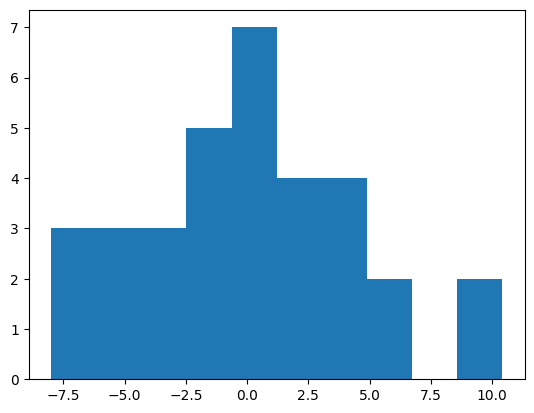

In [64]:
# Test for Normal distribution
plt.hist(residuals_test)

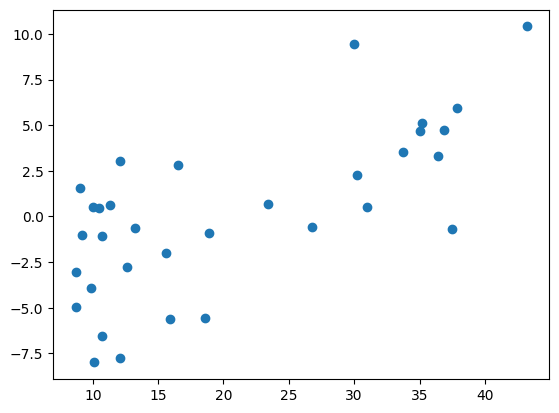

In [71]:
# Test for constant variance
plt.scatter(y_test, residuals_test)

In [76]:
# Autocorrelation check
autocorrelation(residuals_test)


Ho: There is no correlation among residuals
Ha: There is correlation between residuals
2.240861029882474
Do not reject Ho. There is no correlation among residuals.
